In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import os
import warnings
import functools
import seaborn as sns
import scipy.stats
import anndata
import tools

warnings.filterwarnings('ignore')
os.chdir(os.path.expanduser('/lustre/scratch117/cellgen/team297/kt16/Prostate_analysis/scanpy'))
sc.settings.verbosity = 3
sc.logging.print_header()

scanpy==1.7.2 anndata==0.7.6 umap==0.5.1 numpy==1.20.2 scipy==1.6.2 pandas==1.2.4 scikit-learn==0.24.2 statsmodels==0.12.2 python-igraph==0.9.1


In [2]:
from collections import defaultdict

adata = defaultdict(dict)

In [3]:
adata['CRPC-normal'] = sc.read_h5ad('dataset/Chen/chen_11.h5ad')
adata['PRAD'] = sc.read_h5ad('dataset/Chen/chen_13.h5ad')

for f in adata:
    adata[f].layers["counts"] = adata[f].X.copy()
    print(adata[f])

AnnData object with n_obs × n_vars = 46117 × 39899
    obs: 'barcode', 'study', 'sample', 'group'
    var: 'GeneID'
    layers: 'counts'
AnnData object with n_obs × n_vars = 36424 × 25044
    obs: 'barcode', 'study', 'sample', 'group'
    var: 'GeneID'
    layers: 'counts'


In [4]:
import dandelion as ddl
for f in adata:
    ddl.pp.recipe_scanpy_qc(adata[f], mito_cutoff = 30)

normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes
    finished (0:00:03)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:03:18)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:21)
running Leiden clustering
    finished: found 38 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:04)
running Leiden clustering
    finished: found 46 clusters and added
    'leiden_R', the cluster labels (adata.obs, categorical) (0:00:00)
running Leiden cluste

running Leiden clustering
    finished: found 129 clusters and added
    'leiden_R', the cluster labels (adata.obs, categorical) (0:00:00)
running Leiden clustering
    finished: found 138 clusters and added
    'leiden_R', the cluster labels (adata.obs, categorical) (0:00:00)
running Leiden clustering
    finished: found 146 clusters and added
    'leiden_R', the cluster labels (adata.obs, categorical) (0:00:00)
running Leiden clustering
    finished: found 160 clusters and added
    'leiden_R', the cluster labels (adata.obs, categorical) (0:00:00)
running Leiden clustering
    finished: found 168 clusters and added
    'leiden_R', the cluster labels (adata.obs, categorical) (0:00:00)
running Leiden clustering
    finished: found 180 clusters and added
    'leiden_R', the cluster labels (adata.obs, categorical) (0:00:00)
running Leiden clustering
    finished: found 189 clusters and added
    'leiden_R', the cluster labels (adata.obs, categorical) (0:00:00)
running Leiden clustering
 

In [5]:
for f in adata:
    adata[f] = adata[f][adata[f].obs['filter_rna'] == False]
    print(adata[f])

View of AnnData object with n_obs × n_vars = 41484 × 39899
    obs: 'barcode', 'study', 'sample', 'group', 'scrublet_score', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'is_doublet', 'filter_rna'
    var: 'GeneID'
    layers: 'counts'
View of AnnData object with n_obs × n_vars = 23486 × 25044
    obs: 'barcode', 'study', 'sample', 'group', 'scrublet_score', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'is_doublet', 'filter_rna'
    var: 'GeneID'
    layers: 'counts'


In [6]:
for f in adata:
    sc.pp.normalize_total(adata[f], target_sum=1e4)
    sc.pp.log1p(adata[f])
    sc.pp.highly_variable_genes(adata[f], min_mean=0.0125, max_mean=3, min_disp=0.5)

normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes
    finished (0:00:01)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


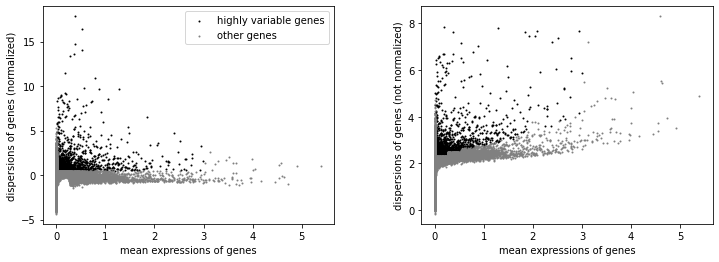

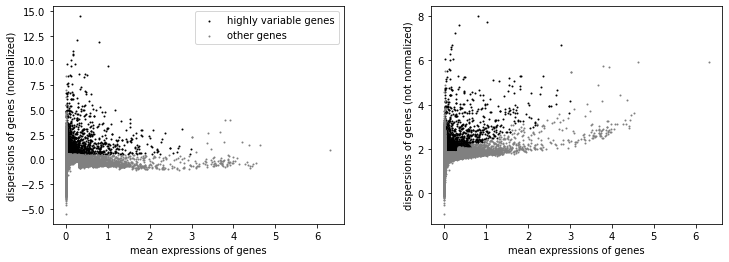

In [7]:
for f in adata:
    sc.pl.highly_variable_genes(adata[f])

In [8]:
for f in adata:
    adata[f].raw = adata[f]
    adata[f] = adata[f][:, adata[f].var.highly_variable]

regressing out ['total_counts', 'pct_counts_mt']
    sparse input is densified and may lead to high memory use
    finished (0:02:08)
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:29)


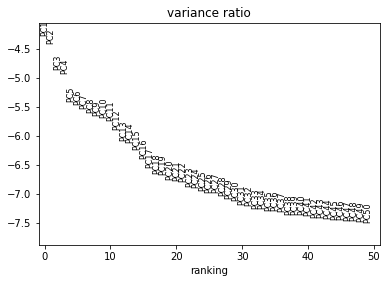

regressing out ['total_counts', 'pct_counts_mt']
    sparse input is densified and may lead to high memory use
    finished (0:00:30)
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:08)


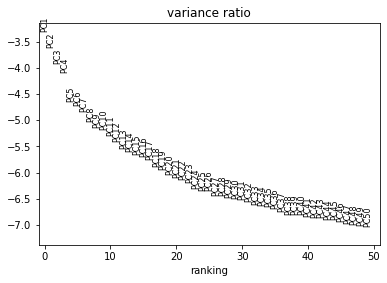

In [9]:
for f in adata:
    sc.pp.regress_out(adata[f], ['total_counts', 'pct_counts_mt'])
    sc.pp.scale(adata[f], max_value=10)
    sc.tl.pca(adata[f], svd_solver='arpack')
    sc.pl.pca_variance_ratio(adata[f], log=True, n_pcs = 50)

In [10]:
import bbknn

computing batch balanced neighbors
	finished: added to `.uns['neighbors']`
	`.obsp['distances']`, distances for each pair of neighbors
	`.obsp['connectivities']`, weighted adjacency matrix (0:00:18)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:01:18)


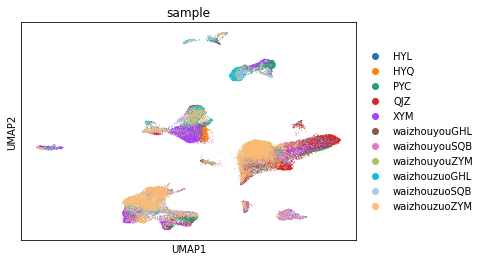

computing batch balanced neighbors
	finished: added to `.uns['neighbors']`
	`.obsp['distances']`, distances for each pair of neighbors
	`.obsp['connectivities']`, weighted adjacency matrix (0:00:12)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:41)


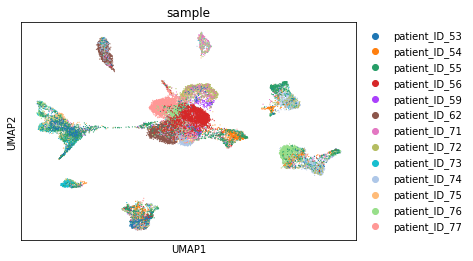

In [11]:
# sc.external.pp.bbknn not updated yet
for f in adata:
    bbknn.bbknn(adata[f], batch_key='sample')
    sc.tl.umap(adata[f], min_dist = 0.3)
    sc.pl.umap(adata[f], color = 'sample')

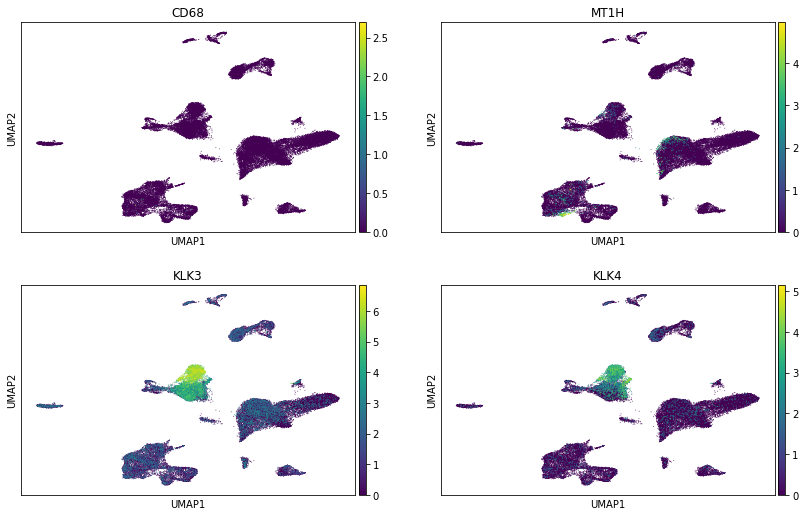

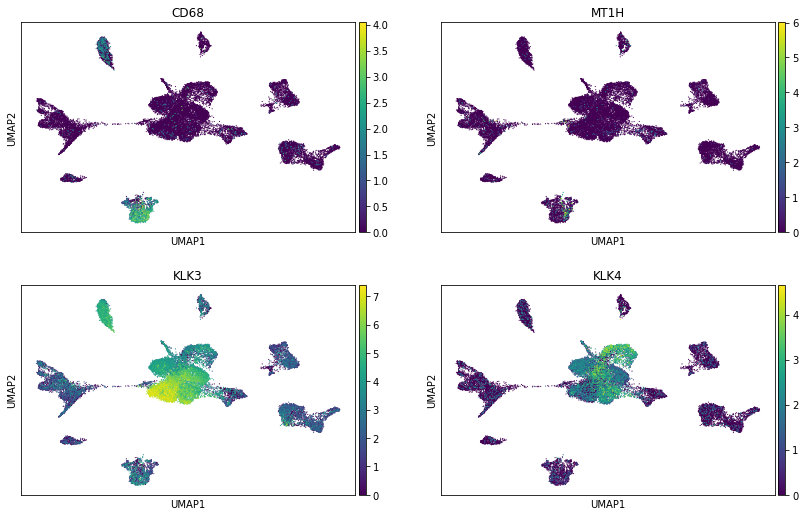

In [12]:
for f in adata:
    sc.pl.umap(adata[f], color = ['CD68', 'MT1H', 'KLK3', 'KLK4'], ncols =2)

running Leiden clustering
    finished: found 19 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:24)


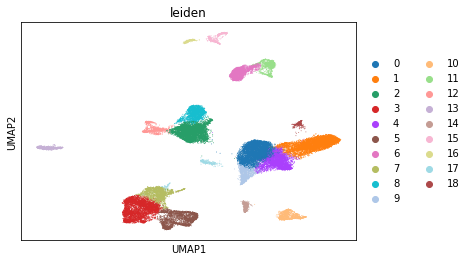

running Leiden clustering
    finished: found 16 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:05)


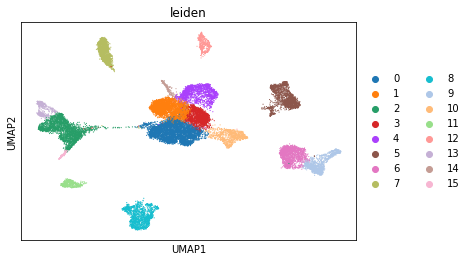

In [13]:
for f in adata:
    sc.tl.leiden(adata[f])
    sc.pl.umap(adata[f], color = 'leiden')

In [14]:
adata['CRPC-normal'].write_h5ad('dataset/Chen/chen_11_filtered.h5ad', compression = 'gzip')
adata['PRAD'].write_h5ad('dataset/Chen/chen_13_filtered.h5ad', compression = 'gzip')

In [15]:
adata

defaultdict(dict,
            {'CRPC-normal': AnnData object with n_obs × n_vars = 41484 × 4646
                 obs: 'barcode', 'study', 'sample', 'group', 'scrublet_score', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'is_doublet', 'filter_rna', 'leiden'
                 var: 'GeneID', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
                 uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'sample_colors', 'leiden', 'leiden_colors'
                 obsm: 'X_pca', 'X_umap'
                 varm: 'PCs'
                 layers: 'counts'
                 obsp: 'distances', 'connectivities',
             'PRAD': AnnData object with n_obs × n_vars = 23486 × 2403
                 obs: 'barcode', 'study', 'sample', 'group', 'scrublet_score', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'is_doublet', 'filter_rna', 'leiden'
                 var: 'GeneID', 'highly_variable', 'means